In [2]:
import pandas as pd
# df = pd.read_csv('../data/samples_in_lightcone0_with_trees_duplicate_excision_outlier_excision.csv')
df = pd.read_hdf('../data/halo_properties_in_lightcone0_with_trees_duplicate_excision.hdf5', key='lightcone')

import sys
sys.path.append('/data1/yujiehe/anisotropy-flamingo')
import tools.xray_correct as xc

In [3]:
# z_obs = df['ObservedRedshift']
z_obs = df['redshift']
Temp = df['GasTemperatureWithoutRecentAGNHeatingCoreExcision'] / 11604525

In [4]:
snap_redshift = (77 - df['snap_num']) * 0.05

In [5]:
L_correction = 1 / (1 + snap_redshift) ** 3
Lx = df['LX0WithoutRecentAGNHeating'] * L_correction
Lx_in_rest_frame = df['LX0InRestframeWithoutRecentAGNHeating'] * L_correction

In [6]:
Lx_k_corred = Lx_in_rest_frame * xc.k_corr(T=Temp, z=z_obs)
print(Lx_k_corred)

0           7.113288e+40
1           1.300278e+41
2           8.838494e+40
3           1.261185e+41
4           1.257786e+41
                ...     
11870832    2.056215e+41
11895427    9.145685e+40
11915059    3.782004e+42
11923119    4.970675e+40
12162491    2.288656e+42
Length: 485545, dtype: float64


In [8]:
import numpy as np
Dco = (df['x_lc']**2 + df['y_lc']**2 + df['z_lc']**2)**0.5 
DL = Dco * (z_obs + 1) * 3.086e24
flux = Lx / (4 * np.pi * DL**2)\
        * xc.band_conv(T=Temp)


In [10]:
print(np.sum(flux > 5e-12))
cut = (flux >= 5e-12) & (np.abs(df['theta_on_lc']) > 20)
print(np.sum(cut))

1075
717


**Plot soap rest frame to K corred**

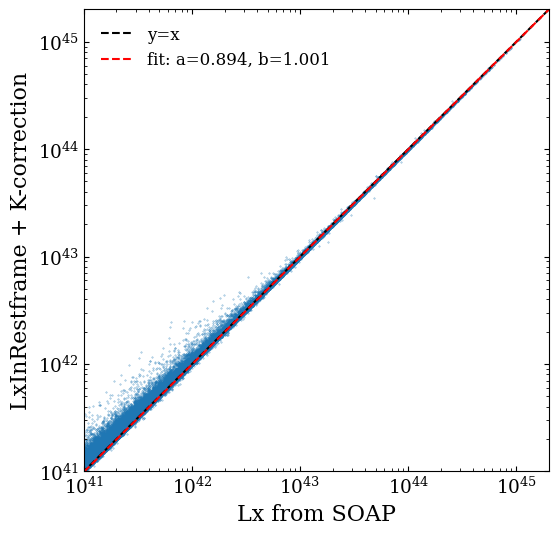

In [24]:
import matplotlib.pyplot as plt
plt.style.use('./nice.mplstyle')
fig=plt.figure(figsize=(6, 6))

plt.scatter(Lx, Lx_k_corred, s=0.1, alpha=0.7)
plt.xlabel('Lx from SOAP')
plt.ylabel('LxInRestframe + K-correction')
plt.plot([0, 2e45], [0, 2e45], 'k--', label='y=x')

# make a linear fit
import numpy as np
from scipy.optimize import curve_fit
def func(x, a, b):
    return a * x**b
popt, pcov = curve_fit(func, Lx, Lx_k_corred)
x = np.linspace(1e41, 2e45, 100)
y = func(x, *popt)
plt.plot(x, y, 'r--', label='fit: a=%5.3f, b=%5.3f' % tuple(popt))

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e41, 2e45)
plt.ylim(1e41, 2e45)

plt.show()

**Compare the K-corr factors**

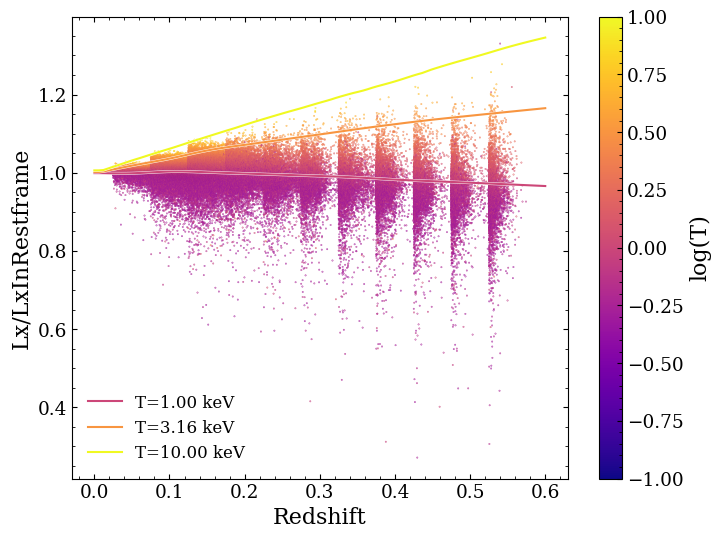

In [25]:
import matplotlib.pyplot as plt
plt.style.use('./nice.mplstyle')
fig=plt.figure(figsize=(8, 6))

from matplotlib.colors import Normalize
norm = Normalize(vmin=-1, vmax=1)

mask             = Temp > 0.5
z_obs            = z_obs[mask]
Lx               = Lx[mask]
Lx_in_rest_frame = Lx_in_rest_frame[mask]
Temp             = Temp[mask]

plt.scatter(z_obs, Lx/Lx_in_rest_frame, c=np.log10(Temp), s=0.1, norm=norm, cmap='plasma')
plt.xlabel('Redshift')
plt.ylabel('Lx/LxInRestframe')


from matplotlib.lines import Line2D
# plot k-correction factors
for log_temp in [0, 0.5,  1]:
    x = np.linspace(0, 0.6, 100)
    y = xc.k_corr(T=np.full(100, 10**log_temp), z=x)
    plt.plot(x, y, color='white', linewidth=2.1)
    plt.plot(x, y, label=f'T={10**log_temp:.2f} keV', color=plt.cm.plasma(norm(log_temp)),
             linewidth=1.5)

plt.legend(loc='lower left')
plt.colorbar(label='log(T)')
# plt.xscale('log')
# plt.yscale('log')

plt.show()